In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('data/train_data_pipelineTest.csv')

# Remove rows with missing target, separate target from predictors
data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = data.SalePrice
X = data.drop(['SalePrice'], axis=1)

# # Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# # "Cardinality" means the number of unique values in a column
# # Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# # Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# # Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

#### We construct the full pipeline in three steps.

Step 1: Define Preprocessing Steps

In [76]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Step 2: Define the Model

In [77]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

Step 3: Create and Evaluate the Pipeline

In [78]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore",category=DeprecationWarning)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

kfold = StratifiedKFold(n_splits=5, random_state=7)
score = cross_val_score(my_pipeline, X_train, y_train, cv=kfold)

# print accuracy from kfolds
print("Avg Accuracy: %.2f%% (%.2f%%)" % (score.mean()*100, score.std()*100))

C:\Users\samer\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\samer\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Avg Accuracy: 79.82% (10.25%)


In [79]:
# fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

In [80]:
from sklearn.metrics import r2_score

print('Training score: ', my_pipeline.score(X_train, y_train))
print('Testing score: ', r2_score(y_valid, preds))

Training score:  0.9747631883753783
Testing score:  0.8273652758891861


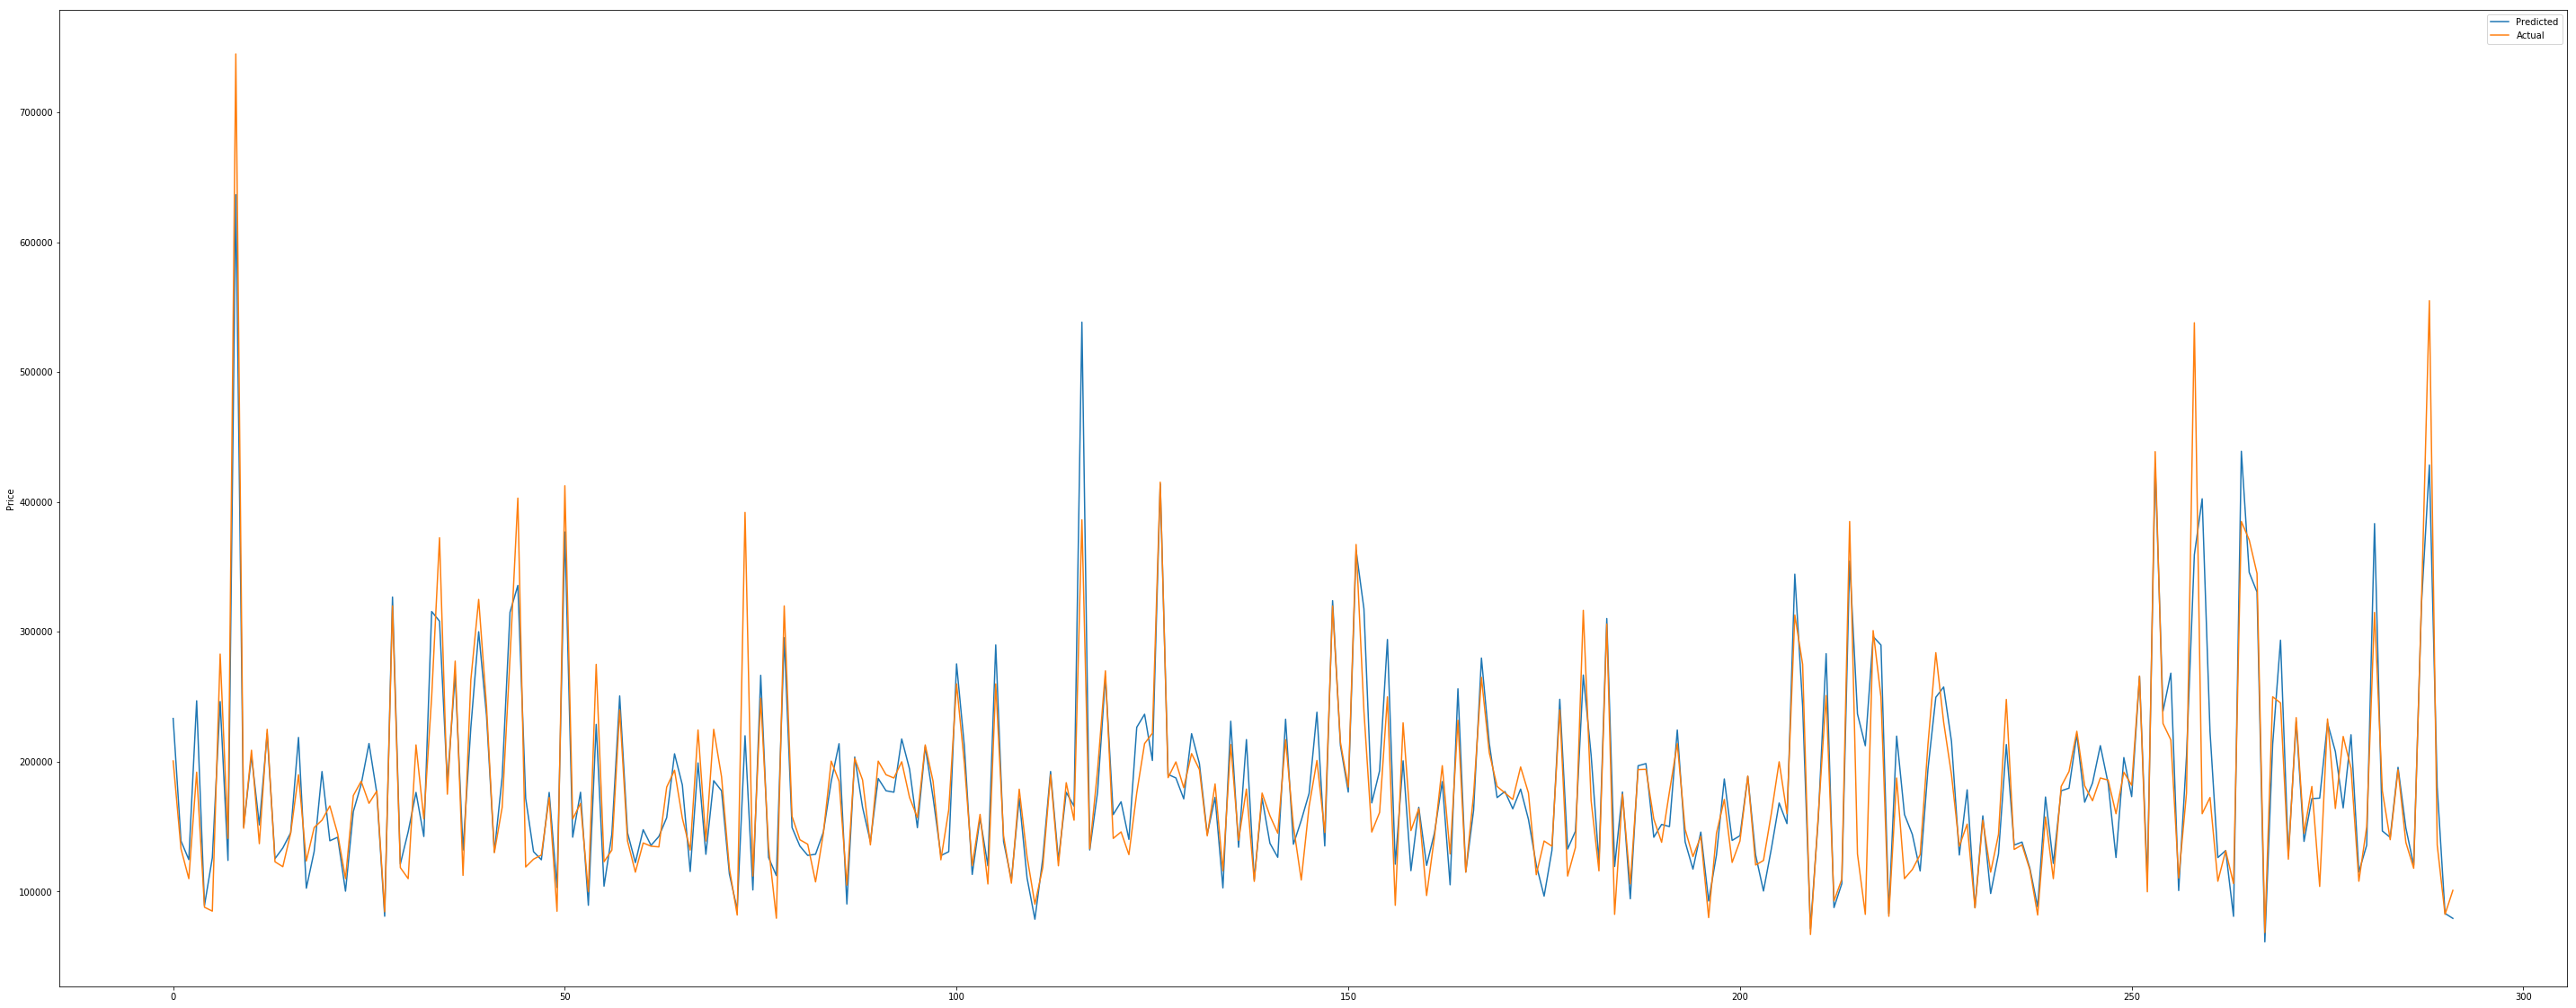

In [81]:
plt.figure(figsize = (50,20))

plt.plot(preds, label='Predicted')
plt.plot(y_valid.values, label='Actual')

plt.ylabel('Price')

plt.legend()
plt.show()

### Predict new data

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


# Read the data
new_data = pd.read_csv('data/test.csv')

# Pick the columns we need to include in the model based on EDA
X_data = new_data[my_cols]

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
# categorical_cols = [cname for cname in n_data.columns if n_data[cname].nunique() < 10 and 
#                         n_data[cname].dtype == "object"]

# Select numerical columns
# numerical_cols = [cname for cname in n_data.columns if n_data[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
# my_cols = categorical_cols + numerical_cols
# X_data = n_data[my_cols].copy()

##### Define Preprocessing Steps ####
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


# Preprocessing of data, get predictions
preds = my_pipeline.predict(X_data)

df_submission = pd.DataFrame({'Id': new_data.Id, 'SalePrice' : preds})

df_submission

,Id,SalePrice
0,1461,122709.32
1,1462,149794.26
2,1463,153200.20
3,1464,186648.00
4,1465,225641.85
...,...,...
1454,2915,82464.75
1455,2916,87902.25
1456,2917,156589.61
1457,2918,104182.50
